<a href="https://colab.research.google.com/github/Rmm6699/HW/blob/master/W9_TA_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 永豐銀行 AI人才培育課程--個人化商品推薦系統 #4

# 目錄 Table of Contents <a class="anchor" id="0.1"></a>

1.	[Dataset and Preprocessing](#1)
2.	[Model Architecture](#2)
    - 2.1	[LightGCN](#2.1)
    - 2.2	[NGCF](#2.2)
    
    
3.	[Loss function and metrics](#3)
    - 3.1	[Bayesian Personalized Ranking loss](#2.1)
    - 3.2	[Metric - Precision, Recall](#2.2)


4.	[Train and evaluate models](#4)

In [ ]:
# Standard library imports
import random
import time

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. Dataset and Preprocessing

We’ll use the [MovieLens 100K dataset](https://files.grouplens.org/datasets/movielens/ml-100k/), which contains 100,000 ratings by 943 users of 1682 items (movies). To ensure the quality of the dataset, each user has rated at least 20 movies. 

We’ll focus on the interactions between users and items, in this case user ratings of movies, but the dataset also provides metadata about users and movies, such as user demographics and movie titles, release dates, and genres. T

The user ratings of movies form a bipartite graph, which we can apply graph machine learning methods to recommend new movies to users.


In [ ]:
columns_name=['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/u.data', sep='\t', names=columns_name)
print(df.shape)
df.head()

(100000, 4)


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


We only want to use high ratings as interactions in order to predict which movies a user will enjoy watching next.

In [ ]:
# How many ratings are a 3 or above?
df = df[df['rating']>=3]
print(df.shape)

(82520, 4)


In [ ]:
# Perform a 80/20 train-test split on the interactions in the dataset
train_df, test_df = train_test_split(df, test_size=0.2, random_state=2022)

print("Train Size: ", len(train_df))
print("Test Size: ", len (test_df))

Train Size:  66016
Test Size:  16504


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively

In [ ]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

print('number of training users:', len(train_user_ids))
print('number of training items:', len(train_item_ids))

test_user_ids = test_df['user_id'].unique()
test_item_ids = test_df['item_id'].unique()

num_nonpst_users = (~np.isin(test_user_ids, train_user_ids)).sum()
num_nonpst_items = (~np.isin(test_item_ids, train_item_ids)).sum()

print('number of non-present users:', num_nonpst_users)
print('number of non-present items:', num_nonpst_items)

number of training users: 943
number of training items: 1549
number of non-present users: 0
number of non-present items: 25


In [ ]:
# drop non-present item row
test_df = test_df[(test_df['user_id'].isin(train_user_ids)) & 
                  (test_df['item_id'].isin(train_item_ids))]

In [ ]:
le_user = LabelEncoder()
le_item = LabelEncoder()
train_df['new_user_id'] = le_user.fit_transform(train_df['user_id'].values)
train_df['new_item_id'] = le_item.fit_transform(train_df['item_id'].values)

In [ ]:
test_df['new_user_id'] = le_user.transform(test_df['user_id'].values)
test_df['new_item_id'] = le_item.transform(test_df['item_id'].values)

In [ ]:
n_users = train_df['new_user_id'].nunique()
n_items = train_df['new_item_id'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  943
Number of unique Items :  1549


## Input Data
    node features
    edge index

###  edge index
PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add n_users to the item tensor to ensure that every node in the graph has a unique identifier.

In [ ]:
train_df

,user_id,item_id,rating,timestamp,new_user_id,new_item_id
35433,339,427,5,891034778,338,425
28540,327,172,4,887743986,326,171
30232,429,81,3,882385243,428,80
40468,593,692,3,886193724,592,684
12008,44,717,3,878346470,43,708
...,...,...,...,...,...,...
69204,918,275,4,891987176,917,274
87088,920,333,4,884219993,919,331
56622,793,458,3,875104243,792,452
20176,215,23,3,891436048,214,22


<img src="./image/image1.png" width="60%">

In [ ]:
u_id = torch.LongTensor(train_df.new_user_id)
i_id = torch.LongTensor(train_df.new_item_id) + n_users # Start from user_id


train_edge_index = torch.stack([u_id, i_id])
print(train_edge_index)
print()

# to undirected graph
train_edge_index = torch.cat([train_edge_index,
                              torch.stack([i_id, u_id])], dim=1).to(device)
'''
tensor([[user_id, user_id, ... ,item_id , item_id, ...],
        [item_id, item_id, ... ,user_id , user_id, ...]])
'''
print(train_edge_index)

tensor([[ 338,  326,  428,  ...,  792,  214,  146],
        [1368, 1114, 1023,  ..., 1395,  965, 1832]])

tensor([[ 338,  326,  428,  ..., 1395,  965, 1832],
        [1368, 1114, 1023,  ...,  792,  214,  146]], device='cuda:0')


Let's confirm that the first and last edges match the middle two edges, but with the order of nodes swapped.

In [ ]:
print(train_edge_index[:,-1], train_edge_index[:, 0])
print(train_edge_index[:, len(train_df)-1], train_edge_index[:, len(train_df)])

tensor([1832,  146], device='cuda:0') tensor([ 338, 1368], device='cuda:0')
tensor([ 146, 1832], device='cuda:0') tensor([1368,  338], device='cuda:0')


<img src="./image/image8.png" width="40%">
<img src="./image/image5.png" width="80%">

## 2. Model Architecture
1. LightGCN, SIGIR 2020. Xiangnan He, Kuan Deng ,Xiang Wang, Yan Li, Yongdong Zhang, Meng Wang (2020). LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation
2. NRGNN, Xiang Wang, Xiangnan He, Meng Wang, Fuli Feng, Tat-Seng Chua (2019). Neural Graph Collaborative Filtering

## 2-1 LightGCN

### LightGCN Convolutional Layer

The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.

In [ ]:
class LightGCNConv(MessagePassing):
    def __init__(self, **kwargs):  
        super().__init__(aggr='add')

    def forward(self, x, edge_index):
        # Compute normalization
        from_, to_ = edge_index
        
        # 1. calculate degree of all nodes 
        deg = degree(to_, x.size(0), dtype=x.dtype)
        
        # 2. square root of node's degree
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # 3. calculate the coefficient of normalization
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # Start propagating messages (no update after aggregation)
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        e_i = x_j
        return norm.view(-1, 1) * e_i

Let's test out our implementation of the LightGCN convolution by applying it to a small bipartite graph.

This sample graph is undirected, and node 0 is connected to nodes 2 and 3 while node 1 is connected to 3 and 4.
<img src="./image/image2.png" width="15%">

In [ ]:
# LightGCNConv Example
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

print('x->\n', test_x, '\n')
print('edge_index->\n', test_edge_index, '\n')

print('degree->\n', degree(test_edge_index[1]), '\n')


print('after aggregation->\n', LightGCNConv()(test_x, test_edge_index))

x->
 tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]) 

edge_index->
 tensor([[0, 0, 1, 1, 2, 3, 3, 4],
        [2, 3, 3, 4, 0, 0, 1, 1]]) 

degree->
 tensor([2., 2., 1., 2., 1.]) 

after aggregation->
 tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])


<img src="./image/image3.png" width="50%">
<img src="./image/image2.png" width="15%">

## 2-2 NGCF

### NGCF Layer

NGCF is an older architecture than LightGCN that originated by researchers who applied [Graph Convolutional Networks (GCNs)]() to recommender systems. LightGCN functions the same as NGCF, but removes the learnable linear layers, non-linear activation, and dropout.

One layer of NGCF updates user and item embeddings as follows:

$$e_{u}^{(k+1)} = \sigma\left(W_1 e_u^{(k)} + \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}(W_1e^{(k)}_i + W_2(e^{(k)}_i \odot e^{(k)}_u))\right)$$

$$e_{i}^{(k+1)} = \sigma\left(W_1 e_i^{(k)} + \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}(W_1e^{(k)}_u + W_2(e^{(k)}_u \odot e^{(k)}_i))\right)$$

Typically, NGCF is implemented with dropout before the activation and with an activation function $\sigma$ of LeakyReLU.

In [ ]:
class NGCFConv(MessagePassing):
    def __init__(self, latent_dim, dropout, bias=True, **kwargs):  
        super(NGCFConv, self).__init__(aggr='add', **kwargs)

        self.dropout = dropout

        self.W1 = nn.Linear(latent_dim, latent_dim, bias=bias)
        self.W2 = nn.Linear(latent_dim, latent_dim, bias=bias)

        self.init_parameters()


    def init_parameters(self):
        nn.init.xavier_uniform_(self.W1.weight)
        nn.init.xavier_uniform_(self.W2.weight)

    def forward(self, x, edge_index):
        
        # 1. calculate self transformation
        x_i = self.W1(x)
        
        # 2. Compute normalization
        from_, to_ = edge_index
        # 2-1 calculate degree of all nodes 
        deg = degree(to_, x.size(0), dtype=x.dtype)
        
        # 2-2 square root of node's degree
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # 2-3 calculate the coefficient of normalization
        norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

        # 2-4 start propagating messages
        x_j = self.propagate(edge_index, x=(x, x), norm=norm)

        # 3. Perform update after aggregation
        out = x_i + x_j
        out = F.dropout(out, self.dropout, self.training)
        out = F.leaky_relu(out)
        
        return out


    def message(self, x_j, x_i, norm):
        return norm.view(-1, 1) * (self.W1(x_j) + self.W2(x_j * x_i))

In [ ]:
# NGCFConv Example
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

print('x->\n', test_x, '\n')
print('edge_index->\n', test_edge_index, '\n')

print(NGCFConv(latent_dim=test_x.shape[0], dropout=0)(test_x, test_edge_index))

x->
 tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]) 

edge_index->
 tensor([[0, 0, 1, 1, 2, 3, 3, 4],
        [2, 3, 3, 4, 0, 0, 1, 1]]) 

tensor([[ 3.4931e-01,  2.0515e-01, -1.8127e-04, -9.1649e-03,  2.0789e+00],
        [-3.1156e-03,  6.8046e-01, -6.2430e-04, -3.4357e-03,  1.5011e+00],
        [ 1.7607e-01,  6.3813e-03,  4.7521e-01, -9.0297e-03,  1.6552e+00],
        [-1.3922e-03,  2.7670e-01, -6.2209e-03, -4.2776e-03,  1.5885e+00],
        [ 2.5324e-02,  9.1321e-01,  5.2798e-01, -1.3485e-03,  1.1919e+00]],
       grad_fn=<LeakyReluBackward0>)


### 2-3 Recommender System GNN

We will use the following class, `RecSysGNN` in order to stack the NGCF or LightGCN convolutional layers. Some considerations that can be made for tweaking the models are the number of layers of your model and dropout. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are `n`-hops away in a model that uses `n` layers. Dropout can be tweaked to try out different regularization schemes.

Notice that our forward function works differently from most neural networks by forward propagating embeddings for all nodes in the graph. This is because the embeddings for a given node depend on the embeddings of it's `n`-hop neighborhood, so they need to be propagated as well.

In [ ]:
class RecSysGNN(nn.Module):
    def __init__(self, latent_dim, num_layers, num_users, num_items, 
                 model, # 'NGCF' or 'LightGCN'
                 dropout=0.1 # Only used in NGCF
    ):
        super(RecSysGNN, self).__init__()

        self.model = model
        self.embedding = nn.Embedding(num_users + num_items, latent_dim) # node features

        if self.model == 'NGCF':
            self.convs = nn.ModuleList(
                NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers))
        else:
            self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

        self.init_parameters()

    def init_parameters(self):
        if self.model == 'NGCF':
            nn.init.xavier_uniform_(self.embedding.weight, gain=1)
        else:
            # Authors of LightGCN report higher results with normal initialization
            nn.init.normal_(self.embedding.weight, std=0.1) 

    def forward(self, edge_index):
        emb_0 = self.embedding.weight
        embeddings = [emb_0] # Collect outputs from every layers
        
        # Neighborhood aggregation
        emb = emb_0
        for conv in self.convs:
            emb = conv(x=emb, edge_index=edge_index)
            embeddings.append(emb)
        
        # Layer Combination
        if self.model == 'NGCF':
            out = torch.cat(embeddings, dim=-1)
        else: # LightGCN
            out = torch.mean(torch.stack(embeddings, dim=0), dim=0)

        return emb_0, out


    def minibatch(self, users, pos_items, neg_items, edge_index):
        emb0, out = self(edge_index) # node features, node embeddings
        return (
            out[users], 
            out[pos_items], 
            out[neg_items], 
            emb0[users],
            emb0[pos_items],
            emb0[neg_items]
        )

## 3. Loss function and metrics

### 3-1 Bayesian Personalized Ranking loss
We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.
<img src="./image/image4.png" width="40%">
<img src="./image/image7.png" width="80%">

In [ ]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0, pos_emb0, neg_emb0):
    

    # compute BPR loss from user, positive item, and negative item embeddings
    pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
    neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

    bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))
    
    # compute loss from initial embeddings, used for regulization
    reg_loss = (1/2) * (user_emb0.norm().pow(2)+ 
                        pos_emb0.norm().pow(2)+
                        neg_emb0.norm().pow(2)) / float(len(users))

    return bpr_loss, reg_loss

### 3-2 Metric - Precision, Recall
<img src="./image/image6.png" width="60%">

In [ ]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
    test_user_ids = torch.LongTensor(test_data['new_user_id'].unique())
    # compute the score of all user-item pairs
    relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

    # create dense tensor of all user-item interactions
    i = torch.stack((
        torch.LongTensor(train_df['new_user_id'].values),
        torch.LongTensor(train_df['new_item_id'].values)
    ))
    v = torch.ones((len(train_df)), dtype=torch.float64)
    interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

    # mask out training user-item interactions from metric computation
    relevance_score = torch.mul(relevance_score, (1 - interactions_t))

    # compute top scoring items for each user
    topk_relevance_indices = torch.topk(relevance_score, K).indices
    topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
    topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
    topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
    topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

    # measure overlap between recommended (top-scoring) and held-out user-item 
    # interactions
    test_interacted_items = test_data.groupby('new_user_id')['new_item_id'].apply(list).reset_index()
    metrics_df = pd.merge(test_interacted_items, topk_relevance_indices_df, 
                          how= 'left', left_on = 'new_user_id',right_on = ['user_ID'])
    metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.new_item_id, metrics_df.top_rlvnt_itm)]

    metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['new_item_id']), axis = 1) 
    metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

    return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## 4. Train and evaluate models

In [ ]:
def train_and_eval(model, optimizer, train_df):
    loss_list_epoch = []
    recall_list = []
    precision_list = []
    
    train_loader = MyDataLoader(train_df, n_users, n_items, 
                                batch_size=BATCH_SIZE, shuffle=True, num_workers=12)
    
    for epoch in tqdm(range(EPOCHS)):
        
        loss_list = []
        
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            users, pos_items, neg_items = [b.to(device) for b in batch]
            users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0 = model.minibatch(users, pos_items, neg_items, train_edge_index)

            bpr_loss, reg_loss = compute_bpr_loss(users, users_emb, 
                                                  pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0)
            loss = bpr_loss + DECAY * reg_loss

            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

        model.eval()
        with torch.no_grad():
            _, out = model(train_edge_index)
            final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
            test_topK_recall,  test_topK_precision = get_metrics(final_user_Embed, final_item_Embed, 
                                                                 n_users, n_items, train_df, test_df, K)

        loss_list_epoch.append(round(np.mean(loss_list),4))
        recall_list.append(round(test_topK_recall,4))
        precision_list.append(round(test_topK_precision,4))
        
        if (epoch+1) %5 == 0:
            print('Epoch: {:02d}, Recall@k: {:.04f}, Precision@k: {:.04f}'.format(
                epoch+1, test_topK_recall, test_topK_precision))
    return (
        loss_list_epoch,
        recall_list, 
        precision_list
    )

### Minibatch Sampling

In [ ]:
class MyDataLoader(DataLoader):
    def __init__(self, data, n_user, n_item, **kwargs):
        super().__init__(dataset=range(len(data)), collate_fn=self.collate_fn, **kwargs)
        self.data = data.loc[:, ['new_user_id', 'new_item_id']]
        self.interected_items_df = data.groupby('new_user_id')['new_item_id'].apply(list).reset_index()
        self.n_user = n_user
        self.n_item = n_item
        
    def collate_fn(self, batch):
        # batch: [0,1,3,2] if batch_size = 4
        
        users = self.data.iloc[batch, 0].values
        pos_items = self.data.iloc[batch, 1].values
    
        users_df = pd.DataFrame(users, columns = ['users'])
        interected_items_df = pd.merge(self.interected_items_df, users_df, 
                                       how = 'right', left_on = 'new_user_id', right_on = 'users')
        
        neg_items = interected_items_df['new_item_id'].apply(lambda x: self.sample_neg(x)).values
        
        return (
            torch.LongTensor(list(users)), # user ids
            torch.LongTensor(list(pos_items)) + self.n_user, # positive item ids
            torch.LongTensor(list(neg_items)) + self.n_user # negative item ids
        )
        
    def sample_neg(self, x):
        while True:
            neg_id = random.randint(0, self.n_item - 1)
            if neg_id not in x:
                return neg_id        
            
loader = MyDataLoader(train_df, n_users, n_items, batch_size=16, shuffle=False, num_workers=4)
next(iter(loader))

(tensor([338, 326, 428, 592,  43, 573, 337,  55, 879, 839, 398, 275,  86, 593,
         373, 605]),
 tensor([1368, 1114, 1023, 1627, 1651, 1187, 1425, 1349, 2203, 1442, 1070, 1697,
         1800, 1123,  973, 1620]),
 tensor([1276, 2367, 2276, 2384, 2463, 2102, 2317, 2051, 1864, 1678, 1711, 2044,
         2358, 2092, 1244, 2389]))

In [ ]:
loader.data

,new_user_id,new_item_id
35433,338,425
28540,326,171
30232,428,80
40468,592,684
12008,43,708
...,...,...
69204,917,274
87088,919,331
56622,792,452
20176,214,22


In [ ]:
loader.interected_items_df

,new_user_id,new_item_id
0,0,"[12, 255, 14, 201, 217, 247, 107, 162, 135, 38..."
1,1,"[277, 276, 110, 282, 257, 298, 303, 295, 285, ..."
2,2,"[348, 340, 332, 337, 343, 347, 345, 342, 180, ..."
3,3,"[359, 322, 354, 10, 257, 263, 49, 259, 357, 32..."
4,4,"[377, 226, 401, 418, 182, 234, 385, 97, 61, 40..."
...,...,...
938,938,"[284, 105, 681, 324, 733, 279, 1260, 918, 977,..."
939,939,"[182, 150, 268, 203, 742, 622, 212, 199, 1121,..."
940,940,"[123, 257, 406, 116, 903, 272, 146, 180, 256, ..."
941,941,"[1012, 233, 312, 878, 425, 681, 78, 130, 214, ..."


In [ ]:
# Hyper-parameters

latent_dim = 64
n_layers = 3 

EPOCHS = 20
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

### Train and evaluate LightGCN

In [ ]:
lightgcn = RecSysGNN(latent_dim=latent_dim, 
                     num_layers=n_layers, 
                     num_users=n_users,
                     num_items=n_items,
                     model='LightGCN').to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2492, 64])]


In [ ]:
light_loss, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

Epoch: 05, Recall@k: 0.2723, Precision@k: 0.1840
Epoch: 10, Recall@k: 0.3009, Precision@k: 0.2037
Epoch: 15, Recall@k: 0.3203, Precision@k: 0.2155
Epoch: 20, Recall@k: 0.3260, Precision@k: 0.2227



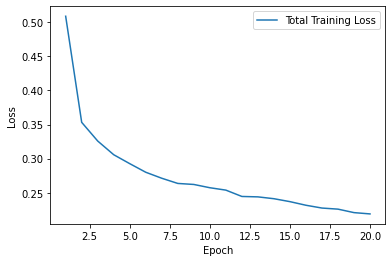

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, light_loss, label='Total Training Loss', alpha=1)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

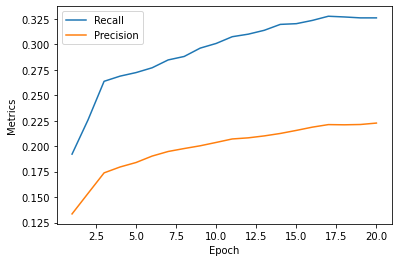

In [ ]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Train and eval NGCF

In [ ]:
ngcf = RecSysGNN(latent_dim=latent_dim, 
                 num_layers=n_layers,
                 num_users=n_users,
                 num_items=n_items,
                 model='NGCF').to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([2492, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [ ]:
ngcf_loss, ngcf_recall, ngcf_precision = train_and_eval(ngcf, optimizer, train_df)

Epoch: 05, Recall@k: 0.2870, Precision@k: 0.1946
Epoch: 10, Recall@k: 0.2964, Precision@k: 0.1994
Epoch: 15, Recall@k: 0.3111, Precision@k: 0.2046
Epoch: 20, Recall@k: 0.3078, Precision@k: 0.2082



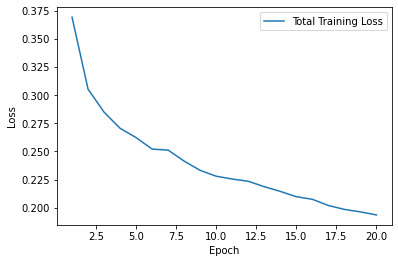

In [ ]:
epoch_list = [(i+1) for i in range(EPOCHS)]
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

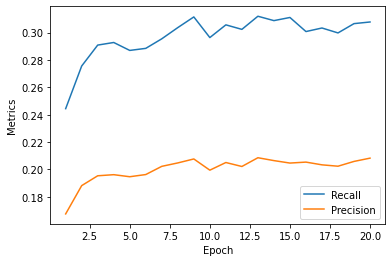

In [ ]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Compare model performance

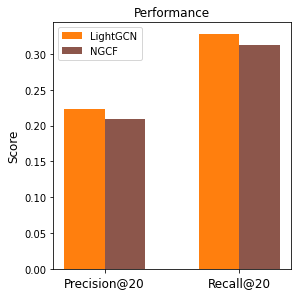

In [ ]:
x = np.arange(2)
width = 0.3

plt.figure(figsize=(4, 4))
plt.bar(x, [max(light_precision), max(light_recall)], width, color='tab:orange', label='LightGCN')
plt.bar(x+0.3, [max(ngcf_precision), max(ngcf_recall)], width, color='tab:brown', label='NGCF')
plt.xticks(x + width / 2, ['Precision@'+str(K), 'Recall@'+str(K)], fontsize=12)
plt.legend()
plt.tight_layout()
plt.ylabel('Score', fontsize=12)
plt.title('Performance', fontsize=12)
plt.show()

-    LightGCN performs better than NGCF with respect to both metrics.